## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
batch_size = 100

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])
    ]
)

train_val = torchvision.datasets.MNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transform
)
test = torchvision.datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transform
)
train, val = torch.utils.data.random_split(
    train_val, 
    [
        int(0.8 * len(train_val)),
        int(0.2 * len(train_val))
    ]
)

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train,
    batch_size=batch_size,
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val,
    batch_size=batch_size,
    shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    test,
    batch_size=batch_size,
    shuffle=False
)

## Explore the Dataset

In [7]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

------ TRAIN ------
8


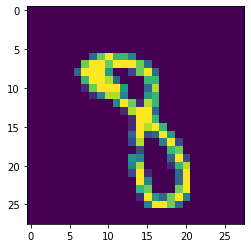

3


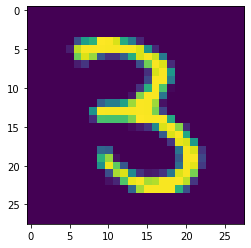

9


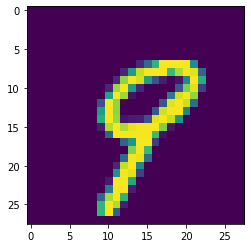

8


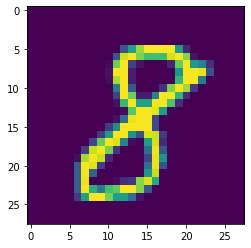

7


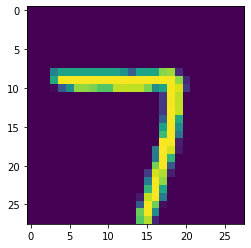

------ TEST ------
7


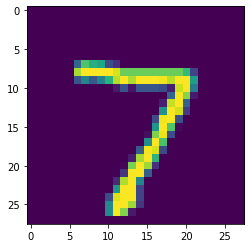

2


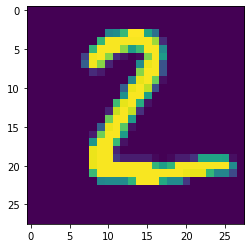

1


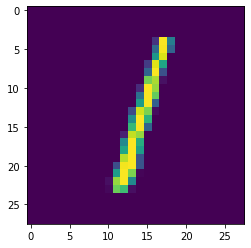

0


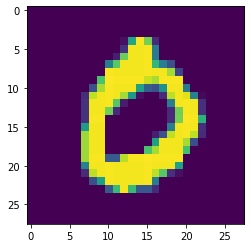

4


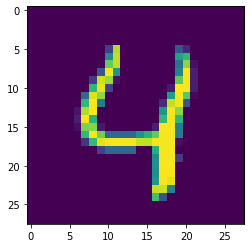

In [8]:
print("------ TRAIN ------")
show5(train_loader)
print("------ TEST ------")
show5(test_loader)

## CNN

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 64, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(64, 256, kernel_size=5, padding=2)
        self.relu3 = nn.ReLU()
        self.linear = nn.Linear(256 * 28 * 28, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = x.view(x.size(0), -1)
        output = self.linear(x)
        return output

In [10]:
net = CNN().to(device)

In [11]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001)

## Training

In [12]:
train_loss_list = []
val_loss_list = []

for epoch in range(10):
    net.train()
    
    train_loss = 0.0
    train_correct = 0
    for _, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()

    print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader):.2f}% training loss: {train_loss/len(train_loader):.5f}')
    train_loss_list.append(train_loss / len(train_loader))

    # Validation
    
    net.eval()

    val_loss = 0.0
    val_correct = 0
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = loss_func(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
    
    print(f'Epoch {epoch + 1} validation accuracy: {val_correct/len(val_loader):.2f}% validation loss: {val_loss/len(val_loader):.5f}')
    val_loss_list.append(val_loss / len(val_loader))

Epoch 1 training accuracy: 23.41% training loss: 2.24318
Epoch 1 validation accuracy: 38.45% validation loss: 2.18778
Epoch 2 training accuracy: 52.21% training loss: 2.11431
Epoch 2 validation accuracy: 59.82% validation loss: 2.03624
Epoch 3 training accuracy: 67.76% training loss: 1.91285
Epoch 3 validation accuracy: 69.59% validation loss: 1.77344
Epoch 4 training accuracy: 75.04% training loss: 1.55841
Epoch 4 validation accuracy: 78.42% validation loss: 1.32753
Epoch 5 training accuracy: 80.51% training loss: 1.08116
Epoch 5 validation accuracy: 82.02% validation loss: 0.87640
Epoch 6 training accuracy: 83.36% training loss: 0.73991
Epoch 6 validation accuracy: 84.34% validation loss: 0.64269
Epoch 7 training accuracy: 85.05% training loss: 0.57912
Epoch 7 validation accuracy: 85.41% validation loss: 0.53605
Epoch 8 training accuracy: 86.35% training loss: 0.49964
Epoch 8 validation accuracy: 86.91% validation loss: 0.47445
Epoch 9 training accuracy: 87.20% training loss: 0.45355

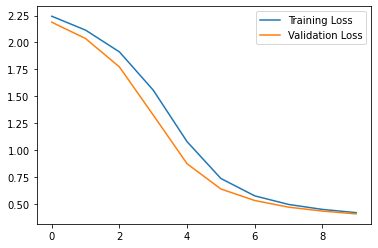

In [14]:
plt.plot(train_loss_list, label="Training Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.legend()
plt.show()

## Testing

In [15]:
count_correct = 0
count_all = 0
net.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)

        count_all += labels.size(0)
        count_correct += (predicted == labels).sum().item()

print(f"Accuracy: {count_correct / count_all}")

Accuracy: 0.891


## Model improvement

In [18]:
net = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

In [19]:
train_loss_list = []
val_loss_list = []

for epoch in range(20):
    net.train()
    
    train_loss = 0.0
    train_correct = 0
    for _, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
        
    print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader):.2f}% training loss: {train_loss/len(train_loader):.5f}')
    train_loss_list.append(train_loss / len(train_loader))

    # Validation
    
    net.eval()

    val_loss = 0.0
    val_correct = 0
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = loss_func(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
    
    print(f'Epoch {epoch + 1} validation accuracy: {val_correct/len(val_loader):.2f}% validation loss: {val_loss/len(val_loader):.5f}')
    val_loss_list.append(val_loss / len(val_loader))

Epoch 1 training accuracy: 65.89% training loss: 1.44943
Epoch 1 validation accuracy: 84.07% validation loss: 0.57109
Epoch 2 training accuracy: 87.23% training loss: 0.43402
Epoch 2 validation accuracy: 89.56% validation loss: 0.35871
Epoch 3 training accuracy: 90.33% training loss: 0.33098
Epoch 3 validation accuracy: 90.88% validation loss: 0.31697
Epoch 4 training accuracy: 91.71% training loss: 0.28538
Epoch 4 validation accuracy: 92.63% validation loss: 0.26022
Epoch 5 training accuracy: 92.64% training loss: 0.25103
Epoch 5 validation accuracy: 93.33% validation loss: 0.23555
Epoch 6 training accuracy: 93.71% training loss: 0.22186
Epoch 6 validation accuracy: 94.21% validation loss: 0.20826
Epoch 7 training accuracy: 94.40% training loss: 0.19715
Epoch 7 validation accuracy: 94.38% validation loss: 0.19508
Epoch 8 training accuracy: 94.99% training loss: 0.17638
Epoch 8 validation accuracy: 95.08% validation loss: 0.16915
Epoch 9 training accuracy: 95.46% training loss: 0.15973

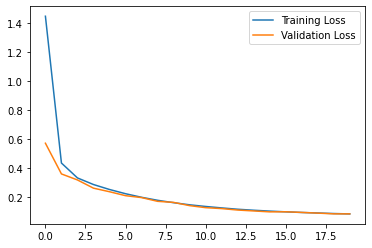

In [20]:
plt.plot(train_loss_list, label="Training Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.legend()
plt.show()

In [22]:
count_correct = 0
count_all = 0
net.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)

        count_all += labels.size(0)
        count_correct += (predicted == labels).sum().item()

print(f"Accuracy: {count_correct / count_all}")

Accuracy: 0.9777


In [23]:
torch.save({
            'epoch': 20,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_func
            }, 'model.pth')